In [80]:
# path library
from pathlib import Path

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data manipulation
import pandas as pd
import numpy as np

# machine learning
from scipy.stats import pointbiserialr
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# random seed to be used throughout
random_seed = 6

# sample size of the data to use for EDA
eda_sample_size = 20000

# sample size of the data to use for hyperparameter tuning
train_sample_size = 10000

In [3]:
# path to processed data
DATA_PATH = Path.cwd().resolve().parents[0] / "data" / "processed" / "processed_data.csv"

In [4]:
df = pd.read_csv(DATA_PATH)

# The data at a glance

In [5]:
df.head()

,month,time,day,hospital,m_age,m_us_born,m_edu,num_of_prenatals,WIC,smoker,...,eclampsia,preterm_births,infert_treatment,prev_c_section,sti,induction,steroids,antibiotics,anesthesia,c_section
0,1,5.016667,2,1,30,1,3,8,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,5.150000,3,1,28,1,6,13,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,5.416666,3,1,41,1,6,11,0,0,...,0,1,0,1,0,0,0,1,1,0
3,1,19.166666,2,0,29,1,4,10,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,22.683332,2,1,28,1,6,13,0,0,...,0,1,0,0,0,0,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3388302 entries, 0 to 3388301
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   month              int64  
 1   time               float64
 2   day                int64  
 3   hospital           int64  
 4   m_age              int64  
 5   m_us_born          int64  
 6   m_edu              int64  
 7   num_of_prenatals   int64  
 8   WIC                int64  
 9   smoker             int64  
 10  m_bmi              float64
 11  pre_diabetes       int64  
 12  gest_diabetes      int64  
 13  pre_hypertension   int64  
 14  gest_hypertension  int64  
 15  eclampsia          int64  
 16  preterm_births     int64  
 17  infert_treatment   int64  
 18  prev_c_section     int64  
 19  sti                int64  
 20  induction          int64  
 21  steroids           int64  
 22  antibiotics        int64  
 23  anesthesia         int64  
 24  c_section          int64  
dtypes: float64(2), int

In [7]:
# Downcast dtypes to optimize memory footprint
fcols = df.select_dtypes('float').columns
icols = df.select_dtypes('integer').columns

df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

# EDA

In [8]:
# We will split the columns into numeric and categorical for the analysis
df.columns

Index(['month', 'time', 'day', 'hospital', 'm_age', 'm_us_born', 'm_edu',
       'num_of_prenatals', 'WIC', 'smoker', 'm_bmi', 'pre_diabetes',
       'gest_diabetes', 'pre_hypertension', 'gest_hypertension', 'eclampsia',
       'preterm_births', 'infert_treatment', 'prev_c_section', 'sti',
       'induction', 'steroids', 'antibiotics', 'anesthesia', 'c_section'],
      dtype='object')

In [9]:
num_cols = ['month', 'time', 'day', 'm_age', 'm_edu', 'num_of_prenatals', 'm_bmi']
cat_cols = ['hospital', 'm_us_born','WIC', 'smoker', 'pre_diabetes',
            'gest_diabetes', 'pre_hypertension', 'gest_hypertension', 'eclampsia',
            'preterm_births', 'infert_treatment', 'prev_c_section', 'sti',
            'induction', 'steroids', 'antibiotics', 'anesthesia', 'c_section']

In [10]:
# We will only use a sample of the data while performing EDA
# to improve compute time.
df_sample = df.sample(eda_sample_size, random_state=random_seed)

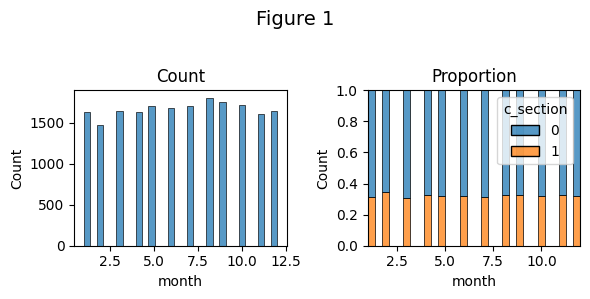

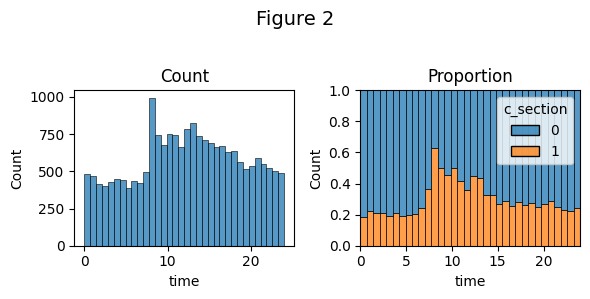

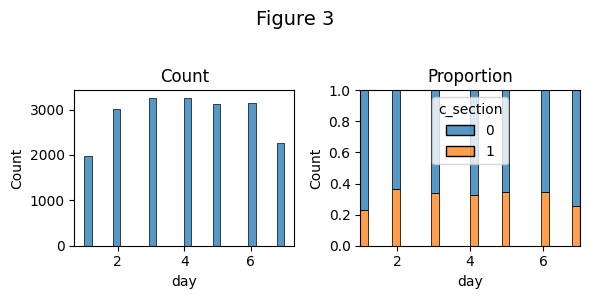

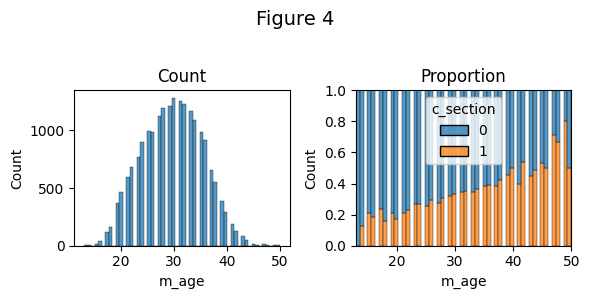

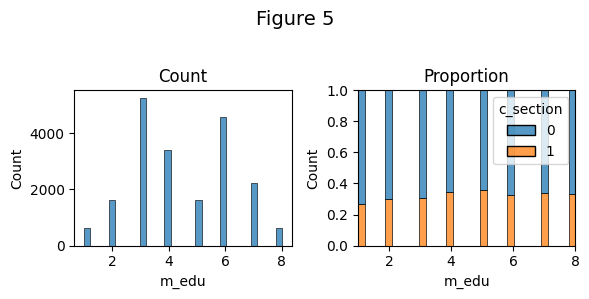

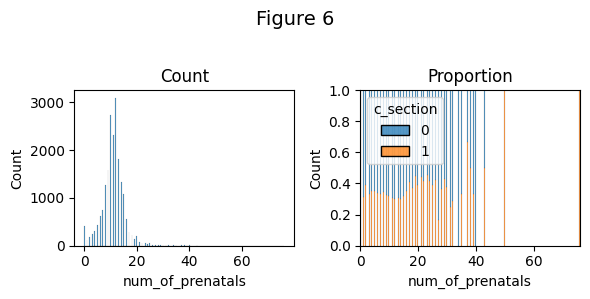

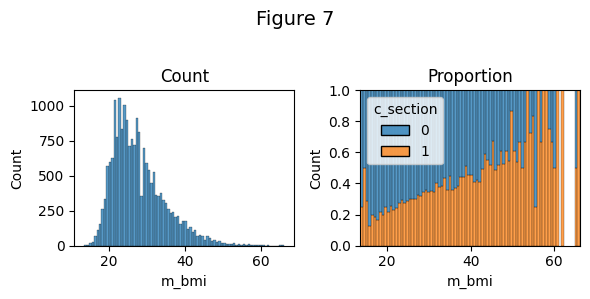

In [11]:
# Pairs of histograms for each numeric column.
# The left histogram shows the count for each column.
# The right histogram shows the proportion of c sections 
# vs vaginal births in each bin.
for i,col in enumerate(num_cols):
    fig, axes = plt.subplots(1, 2, figsize=(6,3))

    sns.histplot(df_sample, x=col, ax=axes[0])
    axes[0].set_title(f'Count')

    sns.histplot(df_sample, x=col, hue='c_section', multiple='fill', ax=axes[1])
    axes[1].set_title(f'Proportion')

    fig.suptitle(f'Figure {i+1}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
    plt.show()

A few observations from the histograms above:
- There is a spike of births, and in particular c-sections, around 8am.
  This could coincide with shift changes in a hospital and planned c-sections.
- There are fewer births and proportionally fewer c-sections on the weekends.
- As the mother's age increases, the rate of c-sections increases.
- Women whose highest level of education is a high school diploma/GED or a Bachelor's degree
  have the greatest representation in the data.
- As BMI inceases, so too does the rate of c-sections with the exception of the lowest BMIs.

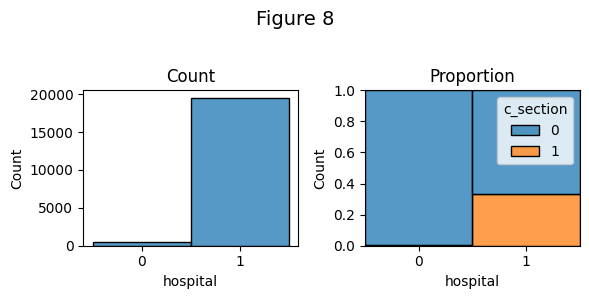

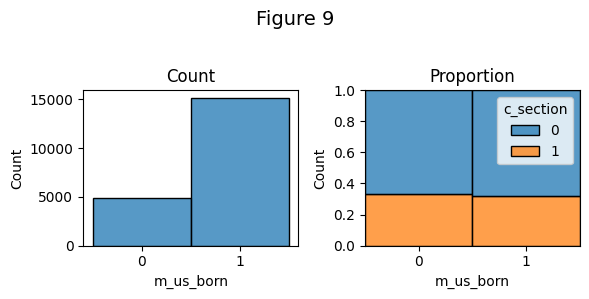

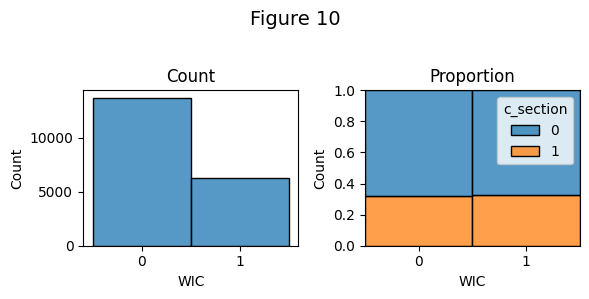

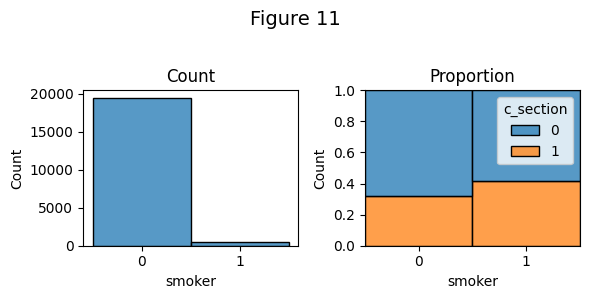

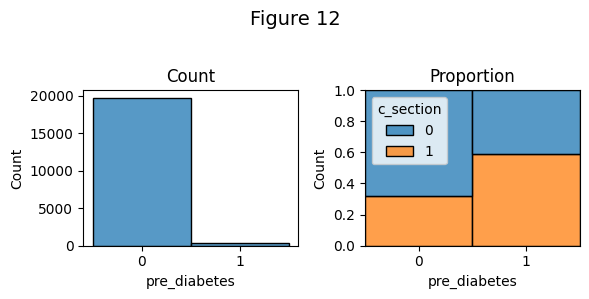

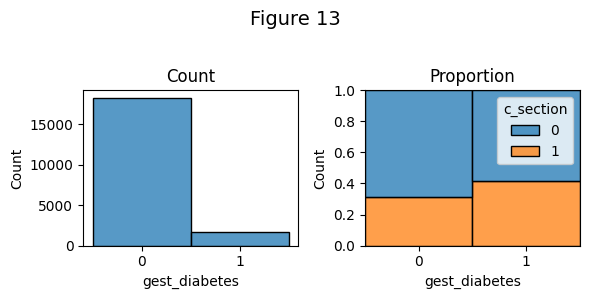

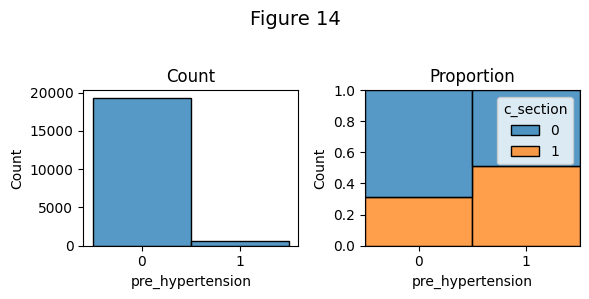

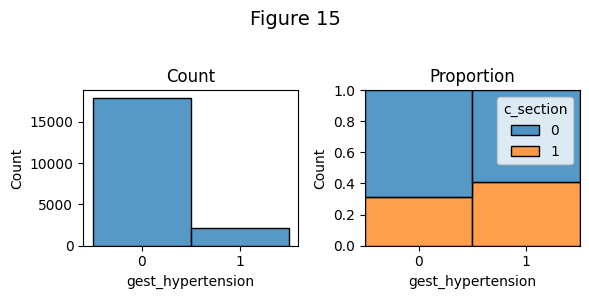

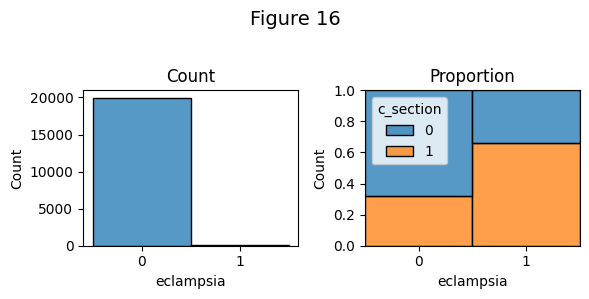

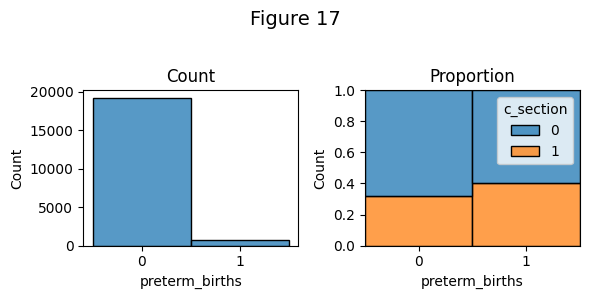

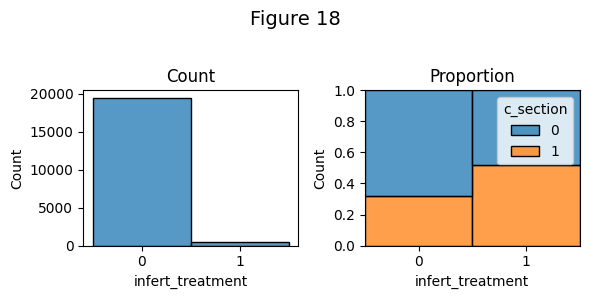

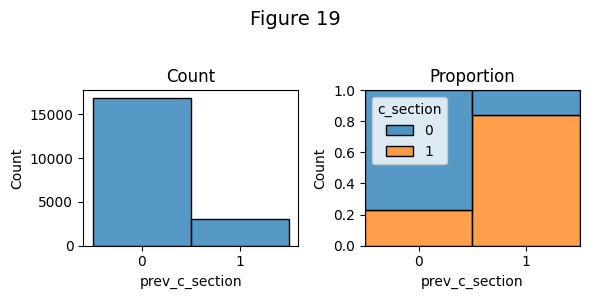

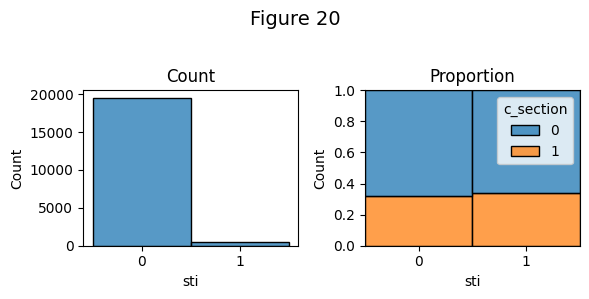

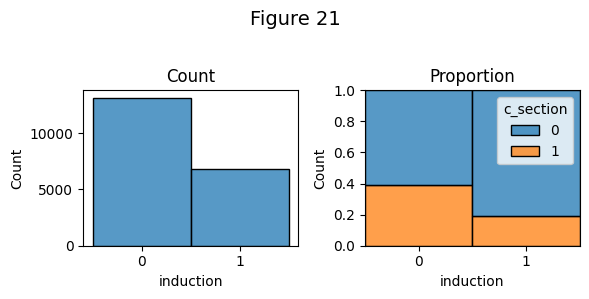

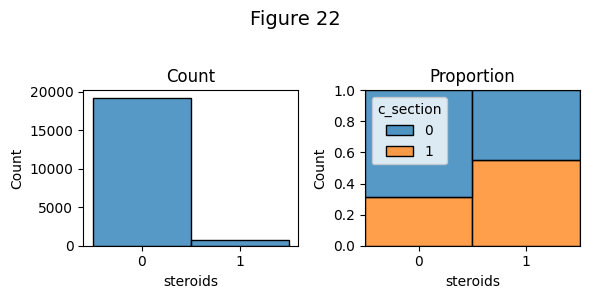

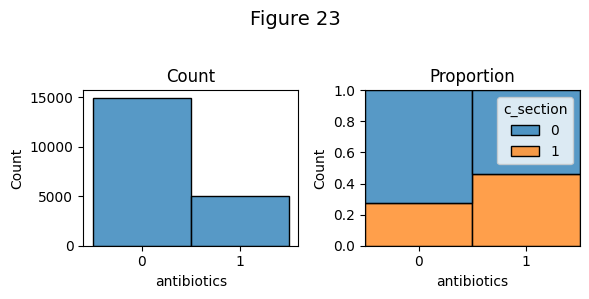

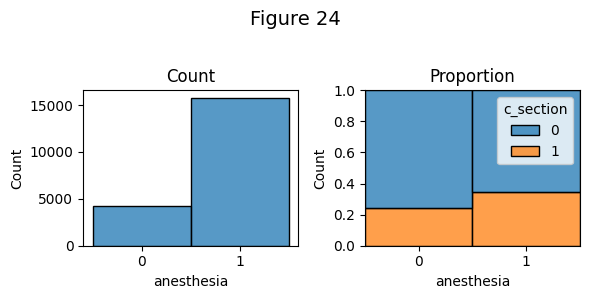

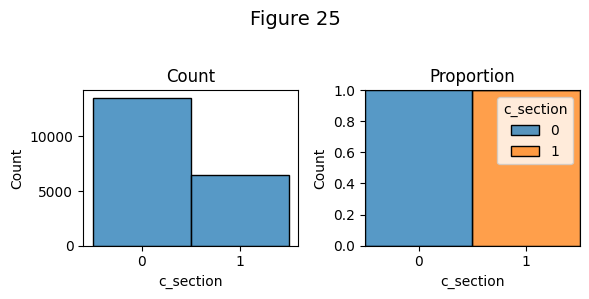

In [12]:
# Pairs of histograms for each categorical column.
# The left histogram shows the count for each column.
# The right histogram shows the proportion of c sections 
# vs vaginal births in each bin.
for i,col in enumerate(cat_cols):
    fig, axes = plt.subplots(1, 2, figsize=(6,3))

    sns.histplot(df_sample, x=col, discrete=True, ax=axes[0])
    axes[0].set_title(f'Count')
    axes[0].set_xticks([0,1])

    sns.histplot(df_sample, x=col, discrete=True, hue='c_section', multiple='fill', ax=axes[1])
    axes[1].set_title(f'Proportion')
    axes[1].set_xticks([0,1])

    fig.suptitle(f'Figure {i+8}', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

A few observations from the histograms above:
- C-sections only occur in hospitals (unsurprising).
- Many of the listed risk factors are associated with an elevated rate of c-sections.
- Having had a previous c-section shows a much greater rate of c-sections.
- The presence of STIs isn't associated with discernably higher rates of c-sections.
- Inductions have fewer c-sections.

Now we will investigate what correlation might be present in the data.

<Axes: >

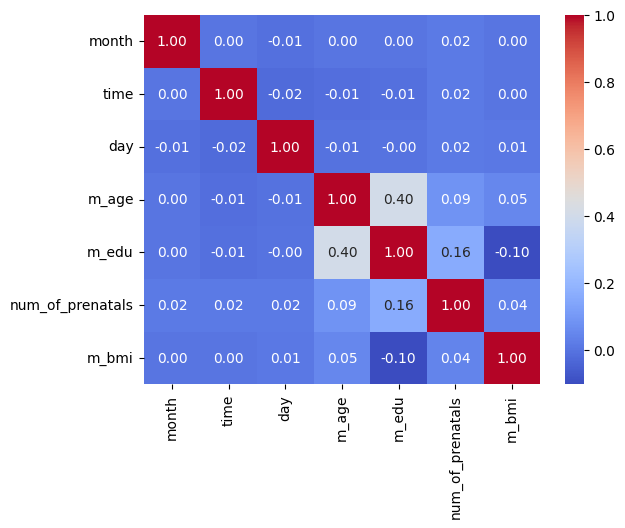

In [13]:
# Pearson correlation coefficient for the variables treated as continuous
sns.heatmap(df_sample[num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')

In [14]:
# Matthews correlation coefficient for the binary variables
mcc_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

for col1 in cat_cols:
    for col2 in cat_cols:
        mcc = matthews_corrcoef(df_sample[col1], df_sample[col2])
        mcc_matrix.loc[col1, col2] = mcc

<Axes: >

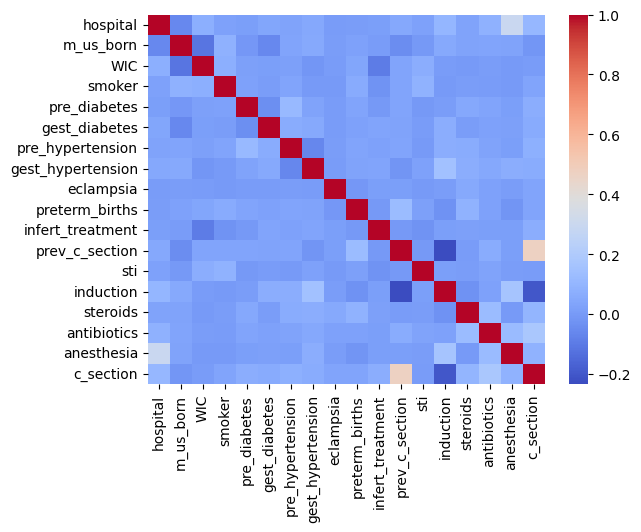

In [15]:
sns.heatmap(mcc_matrix, cmap='coolwarm')

In [16]:
# Point-biserial correlation of binary/continuous pairs
pbc_matrix = pd.DataFrame(index=cat_cols, columns=num_cols, dtype=float)

for col1 in cat_cols:
    for col2 in num_cols:
        r, p_value = pointbiserialr(df_sample[col1], df_sample[col2])
        pbc_matrix.loc[col1, col2] = r

<Axes: >

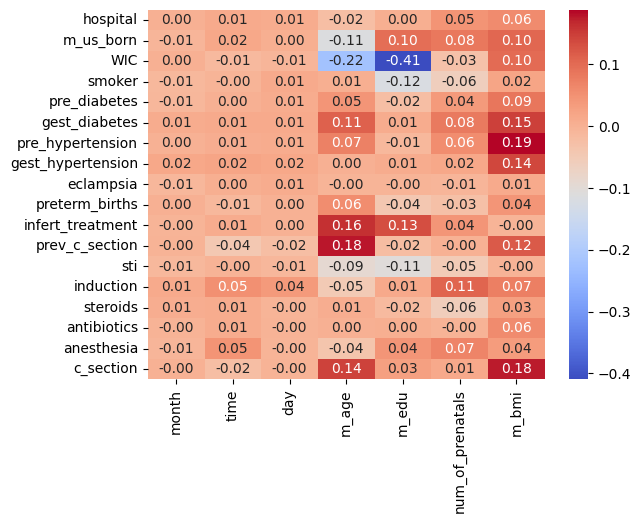

In [17]:
sns.heatmap(pbc_matrix, annot=True, cmap='coolwarm', fmt='.2f')

From the correlation matrices above, we can see that there is very little strong correlation present between the predictors. The highlights worth mentioning:
- The mother's age and education have a correlation of 0.4.
- A c-section birth and having had a previous c-section have a correlation of about 0.4.
- A mother's education and being enrolled in WIC have a correlation of -0.41.

Given this, multicolinearity does not present much of a concern for the interpretability or performance of our models.

# Feature engineering

Since the data is mostly categorical, we will elect to use a Decision Tree classifier
as our benchmark and compare it with the performance of Random Forest and Boosting classifiers.

There are several things we could try when setting up the preprocessor:
- Scale the variables treated as continuous
- Treat month and day as categorical and non-ordinal
- Replace day with a binary feature with weekday/weekend categories
- Replace time with a binary feature with daytime/nighttime categories

The plan:
- We will not scale the continuous variables since we are using tree based methods.
- We will drop month given our computational limitations. Creating dummy
  variables from it would bloat the number of features more than it is likely
  worth. Its predictive power is likely minimal anyway.
- We will replace 'day' with a binary feature 'weekday' given the
  histograms in Figure 3 above. 1 is weekday, 0 is weekend.
- We will replace 'time' with a binary feature 'daytime' given the
  histograms in Figure 2 above. 1 is between 6am and 6pm, else 0.

In [18]:
# recode 'day'
df['day'] = df['day'].apply(lambda x: 0 if (x==1 or x==7) else 1).astype('int8')

In [19]:
# recode 'time'
df['time'] = df['time'].apply(lambda x: 1 if 6<=x<=18 else 0).astype('int8')

In [20]:
# rename day and time and drop month
df.rename(columns={'day': 'weekday', 'time': 'daytime'}, inplace=True)
df.drop(columns='month',inplace=True)

# Models from a sample of the data

When training the models, we will use a small sample from the data
in order to make hyperparameter tuning computationally feasible.
We will then train test split using all the data. This, of course,
would be unnecessary with more computing power.

When evaluating a model, it's worth mentioning that c_sections 
comprise of ~32.4% of all births in 2024, so a model should have 
an accuracy score of at least 0.676 to be better than the 
trivial classifier. For predictions, we must also evaluate the model's 
recall score. Not getting a c-section when it is medically necessary
is much more dangerous than getting a c-section that isn't necessary.

In [21]:
df['c_section'].sum() / len(df['c_section'])

np.float64(0.32414023307249473)

In [22]:
df_train = df.sample(train_sample_size, random_state=random_seed)

In [23]:
X = df_train[df_train.columns[:-1]]
y = df_train['c_section']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_seed)

In [35]:
# Print the accuracy score, recall score, and confusion matrix
def model_eval(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = [0, 1]
    cm_df = pd.DataFrame(cm, 
                         index=[f"True {label}" for label in labels],
                         columns=[f"Pred {label}" for label in labels])
    print(cm_df,end='\n\n')
    print(f"Accuracy score: {accuracy_score(y_true, y_pred)}")
    print(f"Recall score: {recall_score(y_true, y_pred)}")

## Decision Tree - out of the box

In [26]:
dt = DecisionTreeClassifier(random_state=random_seed)

In [27]:
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,6
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [28]:
y_pred = dt.predict(X_test)

In [37]:
# The accuracy score is only slightly better than the trivial classifier.
# The recall score leaves much to be desired.
model_eval(y_test, y_pred)

        Pred 0  Pred 1
True 0    1735     510
True 1     481     574

Accuracy score: 0.6996969696969697
Recall score: 0.5440758293838862


## Decision Tree - GridSearchCV

In [38]:
param_grid = {
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,5],
    'ccp_alpha': [0.005 * n for n in range(10)]
}

In [39]:
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=random_seed),
    param_grid=param_grid,
    cv=5,
    scoring='recall'
)

In [40]:
dt_grid.fit(X_train, y_train)

,estimator,DecisionTreeC...andom_state=6)
,param_grid,"{'ccp_alpha': [0.0, 0.005, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...]}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [41]:
# The grid search shows that the out-of-the-box parameters
# yield the best recall score
print(f"Best params: {dt_grid.best_params_}")
print(f"Best recall: {dt_grid.best_score_}")

Best params: {'ccp_alpha': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best recall: 0.5636604548695735


## Random Forest - out of the box

In [42]:
rf = RandomForestClassifier(random_state=random_seed)

In [43]:
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [44]:
y_pred = rf.predict(X_test)

In [46]:
# The accuracy score has increased by nearly 10%
# but the recall score decreased by about 3.3%.
model_eval(y_test, y_pred)

        Pred 0  Pred 1
True 0    2055     190
True 1     515     540

Accuracy score: 0.7863636363636364
Recall score: 0.5118483412322274


## Random Forest - GridSearchCV

In [47]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [48]:
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=random_seed, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='recall'
)

In [49]:
rf_grid.fit(X_train, y_train)

,estimator,RandomForestC...andom_state=6)
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'recall'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [50]:
# The grid search only finds a single better parameter than the
# out-of-the-box parameters but a lower recall score for CV
print(f"Best params: {rf_grid.best_params_}")
print(f"Best recall: {rf_grid.best_score_}")

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best recall: 0.5082968394999291


In [51]:
rf_best = RandomForestClassifier(min_samples_split=5, random_state=random_seed)

In [52]:
rf_best.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [53]:
y_pred = rf_best.predict(X_test)

In [54]:
# This model only shows trivial increases in
# accuracy and recall
model_eval(y_test, y_pred)

        Pred 0  Pred 1
True 0    2074     171
True 1     513     542

Accuracy score: 0.7927272727272727
Recall score: 0.5137440758293839


## Boosting - out of the box

In [55]:
gb = GradientBoostingClassifier(random_state=random_seed)

In [56]:
gb.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [57]:
y_pred = gb.predict(X_test)

In [59]:
# The accuracy score is comparable to the random forest
# models with a noticeable dip in its recall score
model_eval(y_test, y_pred)

        Pred 0  Pred 1
True 0    2123     122
True 1     559     496

Accuracy score: 0.7936363636363636
Recall score: 0.47014218009478675


## Boosting - GridSearchCV

In [60]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5, 10],
    'subsample': [1.0, 0.8, 0.6]
}

In [61]:
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=random_seed),
    param_grid=param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

In [62]:
gb_grid.fit(X_train, y_train)

,estimator,GradientBoost...andom_state=6)
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...], 'subsample': [1.0, 0.8, ...]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'log_loss'


In [63]:
print(f"Best params: {gb_grid.best_params_}")
print(f"Best recall: {gb_grid.best_score_}")

Best params: {'learning_rate': 0.1, 'min_samples_split': 2, 'n_estimators': 500, 'subsample': 0.6}
Best recall: 0.5364446641098634


In [64]:
gb_best = GradientBoostingClassifier(
    n_estimators=500,
    subsample=0.6,
    random_state=random_seed
)

In [65]:
gb_best.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,500
,subsample,0.6
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [66]:
y_pred = gb_best.predict(X_test)

In [68]:
# This model is also slightly worse than the random forest model.
model_eval(y_test, y_pred)

        Pred 0  Pred 1
True 0    2041     204
True 1     517     538

Accuracy score: 0.7815151515151515
Recall score: 0.5099526066350711


# Final model using all data

The model we will select to train using the entire dataset is a 
random forest model with the hyperparameters found in the grid search.

In [69]:
X = df[df.columns[:-1]]
y = df['c_section']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_seed)

In [72]:
rf_final = RandomForestClassifier(min_samples_split=5, random_state=random_seed)

In [76]:
rf_final.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [77]:
y_pred = rf_final.predict(X_test)

In [84]:
# Running the model on the entire dataset has virtually no effect
# on its accuracy and only a mild improvement on the recall.
model_eval(y_test, y_pred)

        Pred 0  Pred 1
True 0  688788   67117
True 1  166962  195273

Accuracy score: 0.7906532276816857
Recall score: 0.5390782227007329


In [85]:
importances = rf_final.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_final.estimators_], axis=0)

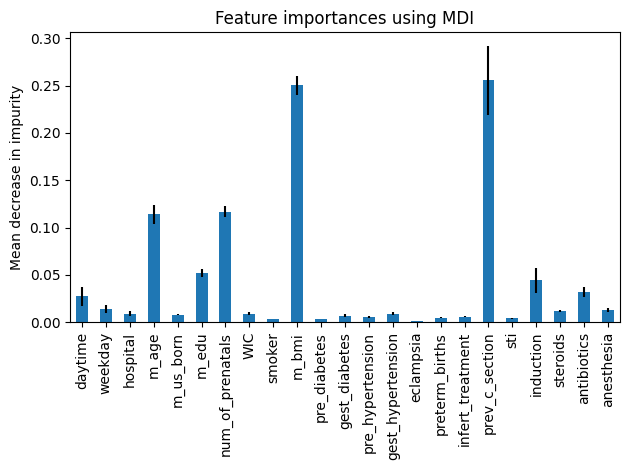

In [86]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()